In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from google.colab import files
import matplotlib.pyplot as plt

# **Get The Kaggle Dataset**

[Dataset Link](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

Get the Kaggle API KEY as mentioned in the [steps](https://www.kaggle.com/docs/api#authentication)

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"<username>","key":"<api_key>"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

# **Download The Dataset**

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:42<00:00, 24.7MB/s]
100% 2.29G/2.29G [01:42<00:00, 24.1MB/s]


**Unzip The dataset**

In [ ]:
!unzip 'chest-xray-pneumonia.zip' -d chest-xray-pneumonia

# **Preprocess and analysis**

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator( 
	rescale=1./255,
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# Train generator for train folder
train_generator = datagen.flow_from_directory(
    "chest-xray-pneumonia/chest_xray/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

# Test generator for test folder
test_generator = datagen.flow_from_directory(
    "chest-xray-pneumonia/chest_xray/test",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

# validation generator for val folder
val_generator = datagen.flow_from_directory(
    "chest-xray-pneumonia/chest_xray/val",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# **Create the MobileNetV2 CNN model**

**We are creating a CNN model using keras with input shape as (224,224,3) which stands for 35x35 RGB pictures . Refer [link](https://keras.io/api/layers/convolution_layers/convolution2d/)**


In [ ]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = False

inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
pretrained_model = mobilenet(inputs, training=False)
dense = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model)
outputs = tf.keras.layers.Dense(2, activation='sigmoid')(dense)
model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_10 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_11 (Dense)            (None, 2)                 2050      
                                                                 
Total params: 3,571,778
Trainable params: 1,313,794
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

**Training the Keras Model**

In [ ]:
epochs = 10

checkpoint = ModelCheckpoint('model.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=test_generator, 
                    validation_steps=len(test_generator),
                    callbacks=[checkpoint])

Epoch 1/10
82/82 [==============================] - 106s 1s/step - loss: 0.2232 - accuracy: 0.9105 - auc: 0.9699 - val_loss: 0.5943 - val_accuracy: 0.7853 - val_auc: 0.8873
Epoch 2/10
82/82 [==============================] - 102s 1s/step - loss: 0.1368 - accuracy: 0.9480 - auc: 0.9881 - val_loss: 0.4186 - val_accuracy: 0.8429 - val_auc: 0.9258
Epoch 3/10
82/82 [==============================] - 101s 1s/step - loss: 0.1378 - accuracy: 0.9440 - auc: 0.9883 - val_loss: 0.4492 - val_accuracy: 0.8205 - val_auc: 0.9215
Epoch 4/10
82/82 [==============================] - 102s 1s/step - loss: 0.1228 - accuracy: 0.9486 - auc: 0.9908 - val_loss: 1.0084 - val_accuracy: 0.7228 - val_auc: 0.8431
Epoch 5/10
82/82 [==============================] - 101s 1s/step - loss: 0.1118 - accuracy: 0.9544 - auc: 0.9922 - val_loss: 0.5233 - val_accuracy: 0.8189 - val_auc: 0.9096
Epoch 6/10
82/82 [==============================] - 102s 1s/step - loss: 0.1105 - accuracy: 0.9561 - auc: 0.9924 - val_loss: 0.8787 - v

# **Loss and Accuracy Curves**

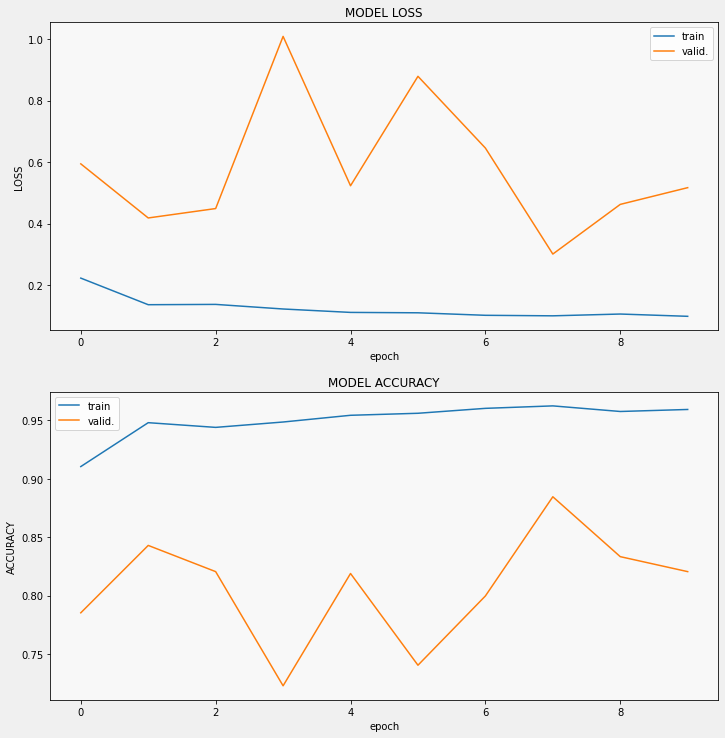

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('MODEL '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'LOSS',
    211,
)

display_training_curves(
    history.history['accuracy'],
    history.history['val_accuracy'],
    'ACCURACY',
    212,
)


# **Accuracy**

Checking Accuracy with respect to the test data

In [ ]:
score = model.evaluate(test_generator,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

10/10 [==============================] - 10s 1s/step - loss: 0.5097 - accuracy: 0.8221 - auc: 0.9090
Accuracy: 82.21%
Loss:  0.5097222924232483


Checking Accuracy with respect to the validation data

In [ ]:
score = model.evaluate(val_generator,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

1/1 [==============================] - 0s 324ms/step - loss: 0.7421 - accuracy: 0.6875 - auc: 0.8418
Accuracy: 68.75%
Loss:  0.7420690059661865


# **Save The Model**

Refer the [docs](https://www.tensorflow.org/guide/keras/save_and_serialize) from the Tensorflow

In [ ]:
#!mkdir '/content/model'
#model.save('/content/model')